In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from utils_plot import plot_series, plot_train_history, plot_prediction
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [2]:
CONFIG_PATH = '/root/work/artwork_sequence/train_test_configuration'
PLOT_PATH = '/root/work/artwork_sequence/plots'

In [4]:
museum_sequence_path = {
    'x_train' : os.path.join(CONFIG_PATH, 'X_train.csv'),
    'x_test' : os.path.join(CONFIG_PATH, 'X_test.csv'),
    'x_train_matrix' : os.path.join(CONFIG_PATH, 'X_train_matrix.npy'),
    'x_test_matrix' : os.path.join(CONFIG_PATH, 'X_test_matrix.npy')
}
museum_sequence_path

{'x_test': '/root/work/artwork_sequence/train_test_configuration/X_test.csv',
 'x_test_matrix': '/root/work/artwork_sequence/train_test_configuration/X_test_matrix.npy',
 'x_train': '/root/work/artwork_sequence/train_test_configuration/X_train.csv',
 'x_train_matrix': '/root/work/artwork_sequence/train_test_configuration/X_train_matrix.npy'}

## Load data

In [5]:
df_x_train = pd.read_csv(museum_sequence_path['x_train'], index_col=0)
df_x_test = pd.read_csv(museum_sequence_path['x_test'], index_col=0)
x_train_matrix = np.load(museum_sequence_path['x_train_matrix'])
x_test_matrix = np.load(museum_sequence_path['x_test_matrix'])
df_x_train.head()

,tour_path
20,/root/work/datasets/artwork_sequence/rijksmuse...
7,/root/work/datasets/artwork_sequence/rijksmuse...
40,/root/work/datasets/artwork_sequence/prado_cra...
0,/root/work/datasets/artwork_sequence/rijksmuse...
23,/root/work/datasets/artwork_sequence/prado_cra...


## Config data to fit with the model input

Because the **Prediction feature model** split the data into training and validation dataset, it is necessary to give all the data in only one block

**Define timeline**

In [6]:
time = np.arange(x_train_matrix.shape[0] + x_test_matrix.shape[0])
time.shape

(859,)

## Split dataset

**Define window size**

In [7]:
split_time = x_train_matrix.shape[0]

X = np.concatenate((x_train_matrix, x_test_matrix))
#Define feature
x_feature = X[:,0]

#the length mean average of the tours
window_size = 4

batch_size = 128
shuffle_buffer_size = 300

In [8]:
x_feature.shape

(859,)

**Create windowed dataset**

In [9]:
from Prediction_model_feature import Windowed_Dataset

In [10]:
#series = tf.expand_dims(x_feature, axis=-1)
series = x_feature
ds = tf.data.Dataset.from_tensor_slices(series)
ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#ds = ds.shuffle(3)
ds = ds.map(lambda w: (w[:-1], w[-1,0]))
ds = ds.batch(batch_size).prefetch(1)

ValueError: Index out of range using input dim 1; input has only 1 dims for 'strided_slice_1' (op: 'StridedSlice') with input shapes: [?], [2], [2], [2] and with computed input tensors: input[3] = <1 1>.

In [ ]:
for element in ds:
    print(element)
    break

In [11]:
dataset = Windowed_Dataset(x_feature,
                           split_time=split_time,
                           window_size=window_size, 
                           shuffle_buffer=shuffle_buffer_size,
                           train_batch_size=batch_size,
                            val_batch_size=batch_size)

In [12]:
train_set = dataset.get_train_dataset()
val_set = dataset.get_val_dataset()

**Plot example**

(4, 1)


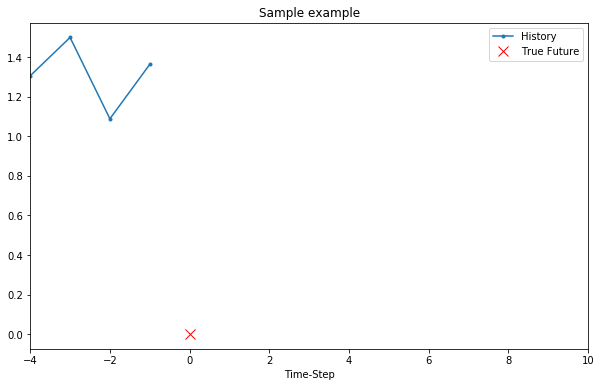

In [13]:
for x, y in train_set.take(1):
    print(x[0].numpy().shape)
    plot = plot_prediction([x[0].numpy(), y[0].numpy()] , 'Sample example')
    #Necessary to save before you plot
    plot.savefig(os.path.join(PLOT_PATH, 'sample_example.png'))
    plot.show()
    

## Define model

In [37]:
def define_model():

    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
      tf.keras.layers.LSTM(window_size, return_sequences=True),
     # tf.keras.layers.LSTM(window_size),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(8, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ],
    name="Sequence_Feature_1")
    
    return model

In [38]:
model = define_model()
model.summary()

Model: "Sequence_Feature_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 4)           592       
_________________________________________________________________
dense (Dense)                (None, None, 16)          80        
_________________________________________________________________
dense_1 (Dense)              (None, None, 8)           136       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           9         
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
______________________________________________

**Train with different learning rates**

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [17]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 3s 687ms/step - loss: 0.7542 - mae: 1.1548
Epoch 2/100
5/5 [==============================] - 0s 26ms/step - loss: 0.7283 - mae: 1.1276
Epoch 3/100
5/5 [==============================] - 0s 27ms/step - loss: 0.6882 - mae: 1.0853
Epoch 4/100
5/5 [==============================] - 0s 28ms/step - loss: 0.6443 - mae: 1.0394
Epoch 5/100
5/5 [==============================] - 0s 26ms/step - loss: 0.6037 - mae: 0.9980
Epoch 6/100
5/5 [==============================] - 0s 25ms/step - loss: 0.5700 - mae: 0.9615
Epoch 7/100
5/5 [==============================] - 0s 25ms/step - loss: 0.5443 - mae: 0.9323
Epoch 8/100
5/5 [==============================] - 0s 26ms/step - loss: 0.5256 - mae: 0.9121
Epoch 9/100
5/5 [==============================] - 0s 26ms/step - loss: 0.5121 - mae: 0.8972
Epoch 10/100
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 25ms/step - loss: 43.3481 - mae: 43.6422
Epoch 85/100
5/5 [==============================] - 0s 24ms/step - loss: 20.6730 - mae: 21.1852
Epoch 86/100
5/5 [==============================] - 0s 25ms/step - loss: 25.4323 - mae: 25.9539
Epoch 87/100
5/5 [==============================] - 0s 22ms/step - loss: 32.2684 - mae: 32.6380
Epoch 88/100
5/5 [==============================] - 0s 23ms/step - loss: 29.2302 - mae: 29.5862
Epoch 89/100
5/5 [==============================] - 0s 24ms/step - loss: 36.5201 - mae: 37.2025
Epoch 90/100
5/5 [==============================] - 0s 31ms/step - loss: 50.8020 - mae: 51.0671
Epoch 91/100
5/5 [==============================] - 0s 27ms/step - loss: 24.0497 - mae: 24.6608
Epoch 92/100
5/5 [==============================] - 0s 24ms/step - loss: 26.8001 - mae: 26.8272
Epoch 93/100
5/5 [==============================] - 0s 23ms/step - loss: 71.2712 - mae: 71.8702
Epoch 94/100
5/5 [==============================] - 0

**Find best learning rate**

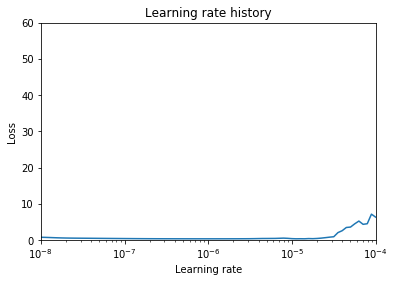

In [18]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.title('Learning rate history')
plt.xlabel("Learning rate")
plt.ylabel("Loss")

plt.savefig(os.path.join(PLOT_PATH, 'learning_rate.png'))
plt.show()

In [ ]:
min_index = np.argmin(np.array(history.history["loss"]))
lr = history.history['lr'][min_index]

In [ ]:
#Best learning rate. WIth this value, the model overfits
lr

**Train with best learning rate**

In [26]:
model = define_model()

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=20,
                    validation_data=val_set)

Epoch 1/20
5/5 [==============================] - 5s 930ms/step - loss: 0.6019 - mae: 0.9906 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 0s 37ms/step - loss: 0.4589 - mae: 0.8489 - val_loss: 0.4108 - val_mae: 0.7924
Epoch 3/20
5/5 [==============================] - 0s 37ms/step - loss: 0.4084 - mae: 0.7714 - val_loss: 0.3712 - val_mae: 0.7669
Epoch 4/20
5/5 [==============================] - 0s 37ms/step - loss: 0.3558 - mae: 0.7374 - val_loss: 0.3212 - val_mae: 0.7083
Epoch 5/20
5/5 [==============================] - 0s 36ms/step - loss: 0.3484 - mae: 0.7293 - val_loss: 0.3271 - val_mae: 0.7188
Epoch 6/20
5/5 [==============================] - 0s 38ms/step - loss: 0.3402 - mae: 0.7214 - val_loss: 0.3368 - val_mae: 0.7299
Epoch 7/20
5/5 [==============================] - 0s 37ms/step - loss: 0.3313 - mae: 0.7151 - val_loss: 0.3222 - val_mae: 0.7105
Epoch 8/20
5/5 [==============================] - 0s 42ms/step - loss: 0.3358 - mae: 0.7

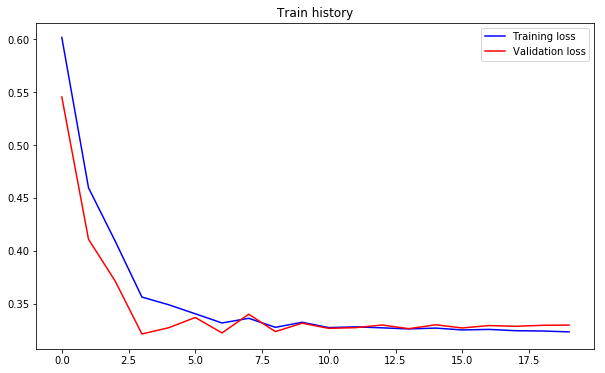

In [27]:
plot = plot_train_history(history, "Train history")
plot.savefig(os.path.join(PLOT_PATH, 'train_history.png'))
plot.show()

## Evaluate model

**Predict time series with the model**

In [28]:
for x, y in val_set.take(3):
    print(x.shape)
    print(y.shape)

(128, 4, 1)
(128,)
(90, 4, 1)
(90,)


**Plot one prediction** 

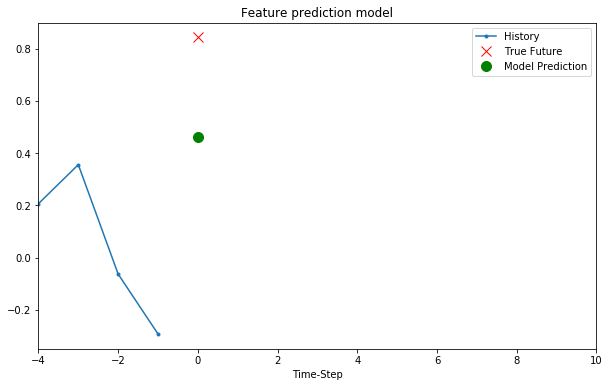

In [29]:
for x, y in val_set.take(1):
    prediction = model.predict(x)[0]
    plot = plot_prediction([x[0].numpy(), y[0].numpy(), prediction[0]] , 'Feature prediction model')
    plot.savefig(os.path.join(PLOT_PATH, 'prediction_single_point.png'))
    plot.show()

**Plot all prediction future**

In [30]:
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:]))
    ds = ds.batch(batch_size)
    forecast = model.predict(ds)
    return forecast

In [31]:
rnn_forecast = model_forecast(model, x_feature, window_size, batch_size)

In [32]:
rnn_forecast = rnn_forecast[split_time-window_size+1:,-1]

In [33]:
rnn_forecast.shape

(222,)

**Plot series**

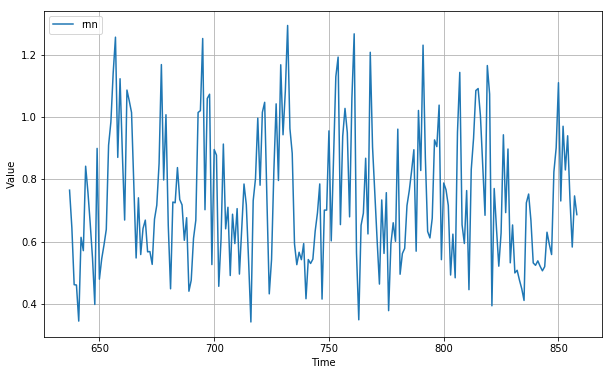

In [34]:
#plot_series(time_train, x_train)
plot = plot_series(time[split_time:], [(rnn_forecast, 'rnn')])
plot.show()

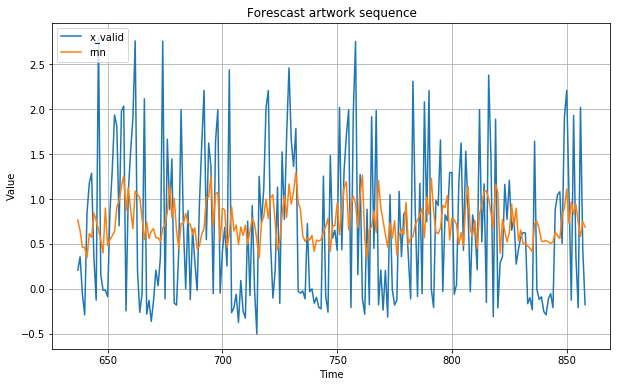

In [35]:
x_valid = x_feature[split_time:]
plot = plot_series(time[split_time:], [(x_valid, 'x_valid'), (rnn_forecast, 'rnn')])
plot.title('Forescast artwork sequence')
plot.savefig(os.path.join(PLOT_PATH, 'forescast_sequence.png'))

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy().mean()

0.69488025